# Moving Average Filter
A moving average filter is a commonly used digital signal processing technique for smoothing out noisy data or reducing fluctuations in a time series. The filter works by calculating the average value of a series of data points over a sliding window of a fixed size.

For example, a 3-point moving average filter would take the average of the current data point and its two neighboring points to generate a new value. As the window slides along the data series, each point is replaced with its moving average value.

Moving average filters can be used to reduce noise in a signal, eliminate high-frequency variations, and highlight trends and patterns in the data

In [1]:
import pandas as pd


jump = pd.read_csv('allJump.csv')
walk = pd.read_csv('allWalk.csv')
both = pd.read_csv('datasetOverall.csv')

#renaming the columns in the dataset so it is easier to call - column names (time, x,y,z,abs) are the same for all datasets
jump = jump.rename(columns={"Time (s)" : "time", "Linear Acceleration x (m/s^2)" : "x", 
                     "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z", 
                     "Absolute acceleration (m/s^2)" : "abs"})

walk = walk.rename(columns={"Time (s)" : "time", "Linear Acceleration x (m/s^2)" : "x", 
                     "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z", 
                     "Absolute acceleration (m/s^2)" : "abs"})

both = both.rename(columns={"Time (s)" : "time", "Linear Acceleration x (m/s^2)" : "x", 
                     "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z", 
                     "Absolute acceleration (m/s^2)" : "abs"})


window_size = 5 * 100  #Choose an appropriate window size (iphone 11 has 100hz rate so 5 * 100)

# Calculate the moving average for each axis
filtered_xj = jump['x'].rolling(window=window_size, center=True).mean()
filtered_yj = jump['y'].rolling(window=window_size, center=True).mean()
filtered_zj = jump['z'].rolling(window=window_size, center=True).mean()
filtered_absj = jump['abs'].rolling(window=window_size, center=True).mean()

filtered_xw = walk['x'].rolling(window=window_size, center=True).mean()
filtered_yw = walk['y'].rolling(window=window_size, center=True).mean()
filtered_zw = walk['z'].rolling(window=window_size, center=True).mean()
filtered_absw = walk['abs'].rolling(window=window_size, center=True).mean()

# Combine filtered acceleration data with time into a new dataframe
filtered_data_jump = pd.DataFrame({'time': jump['time'], 'x': filtered_xj, 'y': filtered_yj, 'z': filtered_zj, 'abs': filtered_absj, 'method': jump['method']})
filtered_data_jump.dropna(inplace=True)  # Remove rows with NaN values due to the moving average calculation


filtered_data_walk = pd.DataFrame({'time': walk['time'], 'x': filtered_xw, 'y': filtered_yw, 'z': filtered_zw, 'abs': filtered_absw, 'method': walk['method']})
filtered_data_walk.dropna(inplace=True) 

#filtered_data_jump and filtered_data_walk are the datasets that we will use for the machine learning



# Feature Extraction

Feature extraction is the process of selecting and transforming relevant information, or "features," from raw data in order to create a new representation that is more meaningful and useful for a specific task

In [2]:
import matplotlib.pyplot as plt

featured = pd.DataFrame(columns = ['max', 'min', 'mean', 'median', 'range', 'std', 'var', 'kurt', 'skew'])

df_abs = filtered_data_jump.iloc[:,4]
max = df_abs.rolling(window= window_size).max()                 
min = df_abs.rolling(window= window_size).min()
mean = df_abs.rolling(window= window_size).mean()
median =df_abs.rolling(window= window_size).median()
range = df_abs.rolling(window= window_size).apply(lambda x: x.max() - x.min())
std = df_abs.rolling(window= window_size).std()
var = df_abs.rolling(window= window_size).var()
kurt = df_abs.rolling(window= window_size).kurt()
skew = df_abs.rolling(window= window_size).skew()

featured['max'] = max                
featured['min'] = min
featured['mean'] = mean
featured['median'] = median
featured['range'] = range
featured['std'] = std
featured['var'] = var
featured['kurt']= kurt
featured['skew'] = skew

featured.dropna(inplace=True)
featured.to_csv('jumpingFeatures.csv', index=False)


#---------------------------------------------
#Feature EXtraction for walking Below
#---------------------------------------------

featured2 = pd.DataFrame(columns = ['max', 'min', 'mean', 'median', 'range', 'std', 'var', 'kurt', 'skew'])

df_abs = filtered_data_walk.iloc[:,4]
max = df_abs.rolling(window= window_size).max()                 
min = df_abs.rolling(window= window_size).min()
mean = df_abs.rolling(window= window_size).mean()
median =df_abs.rolling(window= window_size).median()
range = df_abs.rolling(window= window_size).apply(lambda x: x.max() - x.min())
std = df_abs.rolling(window= window_size).std()
var = df_abs.rolling(window= window_size).var()
kurt = df_abs.rolling(window= window_size).kurt()
skew = df_abs.rolling(window= window_size).skew()

featured2['max'] = max                
featured2['min'] = min
featured2['mean'] = mean
featured2['median'] = median
featured2['range'] = range
featured2['std'] = std
featured2['var'] = var
featured2['kurt']= kurt
featured2['skew'] = skew

featured2.dropna(inplace=True)
featured2.to_csv('walkingFeatures.csv', index=False)


#---------------------------------------------
#Now combine the datasets for training and testing below and normalize the data
#---------------------------------------------

from sklearn.preprocessing import MinMaxScaler


result = pd.concat([filtered_data_jump, filtered_data_walk])

#normalize the data

columns_to_normalize = ['time','x' ,'y','z','abs']
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(result[columns_to_normalize])
result[columns_to_normalize] = normalized_data

result.to_csv('finalCombined.csv', index=False)


# CLassifier Below


Accuracy: 91.61%


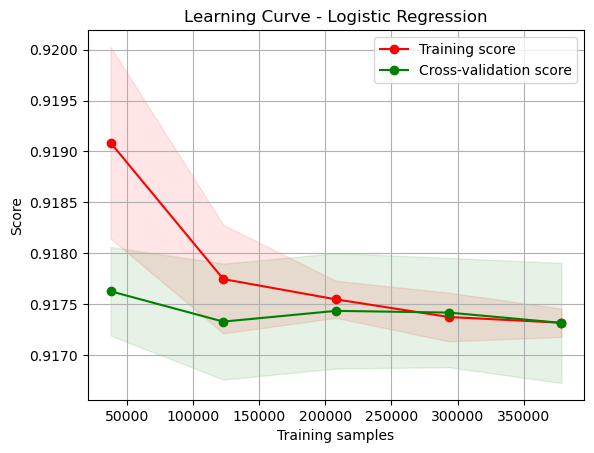

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

X = result.drop("method", axis=1)   # Creates new dataframe with all columns except method
y = result["method"]                # Creates new dataframe with only the method column

# Splits X (the features) and y (the labels/answers) into training and testing sets (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

scaler = StandardScaler()
logreg = LogisticRegression(max_iter=10000)
clf = make_pipeline(scaler, logreg)

# This line fits the machine learning algorithm clf to the training data X_train and y_train. 
# The algorithm learns to map the input features in X_train to the output labels in y_train
clf.fit(X_train, y_train)

# The trained clf algorithm predicts the labels of the test data X_test. The predicted labels are stored in y_pred.
y_pred = clf.predict(X_test)

# The accuracy_score function compares the predicted labels y_pred to the actual labels y_test and returns the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the learning curve
plot_learning_curve(clf, 'Learning Curve - Logistic Regression', X_train, y_train, cv=5)


# Creating the HDF5 Data Storage 
##### Data will be stored based on who recorded and the overall data sets train and test

We added additional groups under the requested "Train", "Test", and group member categories inorder to keep the data more accessible. If a user wanted more granular data they wouldn't have to parse the files. If the overall dataset is needed, the user can easily combine them, whereas separting them is more complicated. 

In [4]:
import numpy as np 
import h5py 

cass_jumping = np.loadtxt(open("C:/Users/Cassie G/Documents/390FinalProject-1/jumping_cg.csv"), delimiter=",", skiprows=1)
cass_walking = np.loadtxt(open("C:/Users/Cassie G/Documents/390FinalProject-1/walking_cg.csv"), delimiter=",", skiprows=1)

leo_jumping = np.loadtxt(open("C:/Users/Cassie G/Documents/390FinalProject-1/jumping_lp.csv"), delimiter=",", skiprows=1)
leo_walking = np.loadtxt(open("C:/Users/Cassie G/Documents/390FinalProject-1/walking_lp.csv"), delimiter=",", skiprows=1)

henry_jumping = np.loadtxt(open("C:/Users/Cassie G/Documents/390FinalProject-1/jumping_hc.csv"), delimiter=",", skiprows=1)
henry_walking = np.loadtxt(open("C:/Users/Cassie G/Documents/390FinalProject-1/walking_hc.csv"), delimiter=",", skiprows=1)

#writing to hdf5
with h5py.File('./hdf5_data.h5' , 'w') as hdf:
    #defining the individual groups on the LHS for Cassie Greidanus
    #Jump and Walk are stored separate under Cassie Greidanus folder
    CG_dataj = hdf.create_group('CassieGreidanus/Jump')
    CG_dataw = hdf.create_group('CassieGreidanus/Walk')

    CG_dataj.create_dataset('cassJump', data=cass_jumping)
    CG_dataw.create_dataset('cassWalk', data=cass_walking)

    #defining the individual groups on the LHS for Leo
    #Jump and Walk are stored separate under Leo's folder
    LP_dataj = hdf.create_group('LeoPalerma/Jump')
    LP_dataw = hdf.create_group('LeoPalerma/Walk')

    LP_dataj.create_dataset('leoJump', data=leo_jumping)
    LP_dataw.create_dataset('leoWalk', data=leo_walking)

    #defining the individual groups on the LHS for Henry
    #Jump and Walk are stored separate under Henry's folder
    HC_dataj = hdf.create_group('HenryChen/Jump')
    HC_dataw = hdf.create_group('HenryChen/Walk')

    HC_dataj.create_dataset('henryJump', data=henry_jumping)
    HC_dataw.create_dataset('henryWalk', data=henry_walking)
    
    #defining the individual groups for train and test
    X_data_train = hdf.create_group('DataSet/Train/X')
    y_data_train = hdf.create_group('DataSet/Train/y')
    
    X_data_test = hdf.create_group('DataSet/Test/X')
    y_data_test = hdf.create_group('DataSet/Test/y')
    
    #storing the data into their respective groups
    
    X_data_train.create_dataset('Training_X', data=X_train)
    y_data_train.create_dataset('Training_y', data=y_train)
    
    X_data_test.create_dataset('Testing_X', data=X_test)
    y_data_test.create_dataset('Testing_y', data=y_test)